# Creating a Time Series Forecast in Python

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Sources:
http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### Imports Python Libraries

In [18]:
# imports

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras

# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from datetime import datetime

### Assigns a Seed to Ensure reproducable results

In [4]:
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

### Imports a csv data set using Panda

In [5]:
# load the dataset
dataframe = pd.read_csv('ignored_assets/AirPassengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

### LSTM-RNN is sensitive to large numbers, so normalizing is a good idea

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Splits the data into training (first 2/3) and test sets (last 1/3)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(dataset[:,0:0])

(94, 47)
[]


### This fn takes two args and returns two datasets: 

A numpy array to be converted into a dataset, and the look_back (default to 1) which his the number of previous values used to predict the next value.


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

### Uses the Above Function to Create the Training and Test sets

In [9]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### The Data Sets are in the Form [sampls, features] so We Reshape to be [samples, time-steps, features]

<b>Samples</b>: Each incident
<br/>
<b>Time Steps</b>: The observations that led up to the incident
<br/>
<b>Features</b>: The variables (or the data) observed

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Uses the LSTM RNN from the Keras Library to Train a Neural Network with the Training Set


In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0103
Epoch 2/100
1s - loss: 0.0058
Epoch 3/100
0s - loss: 0.0053
Epoch 4/100
1s - loss: 0.0050
Epoch 5/100
0s - loss: 0.0047
Epoch 6/100
0s - loss: 0.0044
Epoch 7/100
1s - loss: 0.0044
Epoch 8/100
1s - loss: 0.0042
Epoch 9/100
0s - loss: 0.0041
Epoch 10/100
1s - loss: 0.0040
Epoch 11/100
0s - loss: 0.0039
Epoch 12/100
0s - loss: 0.0039
Epoch 13/100
1s - loss: 0.0038
Epoch 14/100
1s - loss: 0.0039
Epoch 15/100
1s - loss: 0.0037
Epoch 16/100
1s - loss: 0.0038
Epoch 17/100
1s - loss: 0.0037
Epoch 18/100
1s - loss: 0.0036
Epoch 19/100
0s - loss: 0.0036
Epoch 20/100
0s - loss: 0.0035
Epoch 21/100
1s - loss: 0.0036
Epoch 22/100
1s - loss: 0.0035
Epoch 23/100
1s - loss: 0.0034
Epoch 24/100
0s - loss: 0.0033
Epoch 25/100
1s - loss: 0.0033
Epoch 26/100
1s - loss: 0.0034
Epoch 27/100
1s - loss: 0.0036
Epoch 28/100
1s - loss: 0.0034
Epoch 29/100
1s - loss: 0.0033
Epoch 30/100
0s - loss: 0.0032
Epoch 31/100
0s - loss: 0.0031
Epoch 32/100
0s - loss: 0.0032
Epoch 33/100
1s -

### With the Model Trained Above, We Have the Model Attempt to Generate the Last Third

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.65 RMSE
Test Score: 50.49 RMSE


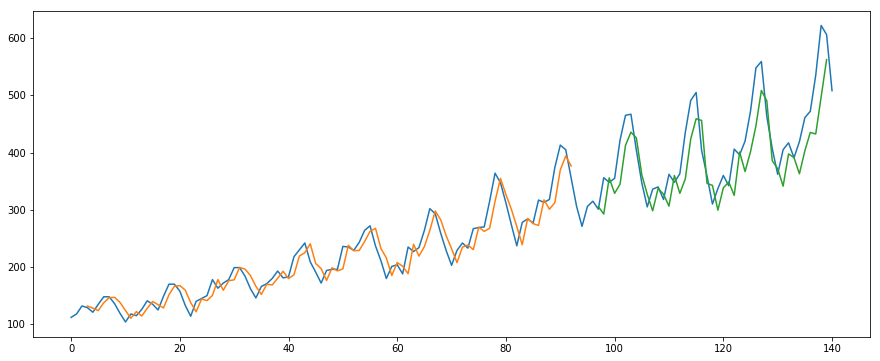

In [13]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<h1 style="font-size:3em; text-align: center">Making The LSTM-RNN Fit The Original Data</h1>

At first, I renamed many of the variables from the above to distinguish between the separate cases. However, I decided it more efficient to generalize the LSTM-RNN into a function for simpification

## Again With The Seeding for Reproducable Results

In [14]:
np.random.seed(69)

## Loads the Original Data Set, and Prepares them for the Neural Network

In [15]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '1H'

# load the dataset
car_dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=3000)
car_dataframe['time_bucket'] = pd.to_datetime(car_dataframe['time_bucket'])
car_dataframe = car_dataframe.set_index('time_bucket')
car_dataframe['total'] = car_dataframe.sum(axis=1)
car_dataframe['day_hour'] = car_dataframe.index.round(time_grouping)

# datasets for two districts in particular
car_dataframe_station_1 = car_dataframe[['1afd7afbc81ecc1b13886a569d869e8a', 'day_hour']].groupby('day_hour').sum();
car_dataset_station_1 = car_dataframe_station_1.values
car_dataset_station_1 = car_dataset_station_1.astype('float32')

car_dataframe_station_2 = car_dataframe[['d4ec2125aff74eded207d2d915ef682f', 'day_hour']].groupby('day_hour').sum();
car_dataset_station_2 = car_dataframe_station_2.values
car_dataset_station_2 = car_dataset_station_2.astype('float32')

# The data set with the sum of all the cars out at the 
car_dataframe = car_dataframe[['total','day_hour']].groupby('day_hour').sum()

car_dataset = car_dataframe.values
car_dataset = car_dataset.astype('float32')

## Generalized the Above Described Process to Work With Most Datasets

In [16]:
def trainAndPredict(dataset, look_2back=1):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    
    
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    temptrainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    temptestY = scaler.inverse_transform([testY])
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    # Shows the original data before attempting to predict
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    # Does the Training
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()


In [17]:
trainAndPredict(car_dataset_station_1, look_back=5)

TypeError: trainAndPredict() got an unexpected keyword argument 'look_back'

In [ ]:
trainAndPredict(car_dataset_station_2, look_back=5)

In [ ]:
trainAndPredict(car_dataset, look_back=20)